In [1]:
from transformers import ViTForImageClassification

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import sys
import logging

/home/moayad/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=8)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
torch.manual_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=16
LEARNING_RATE=0.0001
NUM_EPOCHS = 10
CHECK_VAL_EVERY_N_EPOCH = 1

## Loading Dataset

In [5]:
transformations = torchvision.transforms.Compose([
    # torchvision.transforms.ToPILImage(), # as I upload raw images

    torchvision.transforms.Resize(size=(224,224)), # resize images to the needed size of ResNet50

    torchvision.transforms.ToTensor(), # convert images to tensors

    torchvision.transforms.Normalize( # image are normalized as mentioned in https://huggingface.co/google/vit-base-patch16-224

        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )

])

In [6]:
class medicalImageDataset(Dataset):

    def __init__(self,root_dir, transform=None):

        """Args:
            root_dir (string) : Directory with all images, organized in class folders.
            transform (callable, optional): Transformations to be applied.
        """

        self.root_dir = root_dir
        if transform is None:
            self.transform = transformations
        else:
            self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir)) # returning the names of the folders as each name represents a class

        # We load all images and their respective labels and append their paths to their corresponding lists.

        for label_idx, class_folder in enumerate(self.classes):

            class_folder_path = os.path.join(root_dir,class_folder)

            for img_name in os.listdir(class_folder_path):

                img_path = os.path.join(class_folder_path,img_name)

                self.image_paths.append(img_path)

                self.labels.append(label_idx)


    def __len__(self):

        return len(self.image_paths)

    def __getitem__(self,idx):

        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(img)


        return image,label



In [9]:
TRAIN_DIR = "/home/moayad/Downloads/StFX TA & XP & Student/advanced-project/DataSet_Splitted/train"
VAL_DIR = "/home/moayad/Downloads/StFX TA & XP & Student/advanced-project/DataSet_Splitted/val"
TEST_DIR = "/home/moayad/Downloads/StFX TA & XP & Student/advanced-project/DataSet_Splitted/test"


In [10]:
train_dataset = medicalImageDataset(root_dir=TRAIN_DIR, transform=transformations)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_dataset = medicalImageDataset(root_dir=VAL_DIR, transform=transformations)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_dataset = medicalImageDataset(root_dir=TEST_DIR, transform=transformations)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

### Trainer

In [11]:
def computeAccuracy(outputs, labels):

    """Compute accuracy given outputs as logits.
    """

    preds = torch.argmax(outputs, dim=1)
    return torch.sum(preds == labels) / len(preds)


In [12]:
class Trainer:

    def __init__(self, model):

        self.model = model
        self.model.to(DEVICE)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []


        # logging info
        logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s | %(message)s")
        self.logger = logging.getLogger()

    def train(self,train_loader=train_loader,val_loader=val_loader):

        best_val_acc=0.0 # to save the best fitting model on the validation set

        for epoch in range(NUM_EPOCHS):

            self.model.train()

            # loss tracking metrics

            running_loss=0.0
            running_vloss=0.0
            batch_loss=0.0
            running_acc=0.0
            running_val_acc = 0

            train_pbar = tqdm(enumerate(train_loader), total=len(train_loader))

            for i, (inputs, labels) in train_pbar:

                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)

                loss = self.criterion(outputs.logits, labels)

                running_acc += computeAccuracy(outputs.logits, labels)

                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                batch_loss += loss.item()

                if i % 10 == 0: # calculate average loss across every 10 batches

                    batch_loss = batch_loss / 10
                    train_pbar.set_postfix({"loss": round(batch_loss,5)})
                    batch_loss = 0.0


            # now we compute the average loss and accuracy for each epoch
            train_accuracy_per_epoch = running_acc / len(train_loader)
            self.train_accuracies.append((epoch, train_accuracy_per_epoch.cpu()))

            avg_loss = running_loss / len(train_loader)
            self.train_losses.append((epoch, avg_loss))

            # evaluating the model after certain number of epochs
            if epoch % CHECK_VAL_EVERY_N_EPOCH == 0:

                self.model.eval()

                val_pbar = tqdm(enumerate(test_loader), total=len(test_loader))

                with torch.no_grad():

                    for i, (input,labels) in val_pbar:

                        inputs, labels = input.to(DEVICE), labels.to(DEVICE)

                        outputs = self.model(inputs)

                        loss = self.criterion(outputs.logits, labels)

                        running_vloss+= loss.item()

                        # compute validation accuracy for this epoch

                        running_val_acc += computeAccuracy(outputs.logits,labels)

                val_accuracy_per_epoch = running_val_acc / len(val_loader)
                self.val_accuracies.append((epoch, val_accuracy_per_epoch.cpu()))

                avg_vloss = running_vloss / len(val_loader)
                self.val_losses.append((epoch, avg_vloss))

		# save the best model achieving on val dataset
                if val_accuracy_per_epoch > best_val_acc:

                    best_val_acc = val_accuracy_per_epoch
                    self.saveModel(f"{epoch}_best_model_weights.pth")

                self.logger.info(
                        f"[EPOCH {epoch + 1}] Training Loss= {avg_loss} Validation Loss={avg_vloss} | Training Accuracy={train_accuracy_per_epoch} val={val_accuracy_per_epoch}"
                    )

    def test(self, test_loader=test_loader, best_model_weights_path=None):

        if best_model_weights_path is None:
            pass
        else:
            self.model.load_state_dict(torch.load(best_model_weights_path))
            print('Model into the path is loaded.')

        correct = 0 # we want to know how many images in the test set was predicted correctly (matched the label) so we keep adding the results of this with each batch running with specific input.

        self.model.eval()

        test_pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():

            for i, (input, labels) in test_pbar:

                inputs, labels = input.to(DEVICE), labels.to(DEVICE)

                outputs = self.model(inputs)

                correct+=computeAccuracy(outputs.logits,labels)

        self.logger.info(f"Test accuracy: {(correct / len(test_loader)) * 100}%")

    def saveModel(self, path):
        torch.save(self.model.state_dict(), path)
        self.logger.info(f"Model Saved to {path}")

    def plotMetrics(self):

          os.makedirs("plots", exist_ok=True)

          # extracting iterations and losses

          t_iters = [item[0] for item in self.train_losses]
          t_loss = [item[1] for item in self.train_losses]

          # extracting validation losses without using zip
          v_loss = [item[1] for item in self.val_losses]

          # extracting train & val accuracies
          acc = [item[1] for item in self.train_accuracies]
          v_acc = [item[1] for item in self.val_accuracies]

          fig, ax = plt.subplots(1,2, figsize=(12,5))
          fig.suptitle(f"EfficientNet Trained on Peripheral Blood Cells Dataset")

          ax[0].set_title(f"Loss with Batch Size={BATCH_SIZE} & Learning Rate = {LEARNING_RATE}")
          ax[0].plot(t_iters, t_loss)
          ax[0].plot(t_iters, v_loss)
          ax[0].set_xlabel("Epochs")
          ax[0].set_ylabel("Loss")
          ax[0].legend(["Train", "Validation"])
          ax[0].set_xticks(t_iters[::5])
          ax[0].set_xticklabels(t_iters[::5], rotation=45)


          ax[1].set_title(f"Accuracy with Batch Size={BATCH_SIZE} & Learning Rate = {LEARNING_RATE}")
          ax[1].plot(t_iters,acc)
          ax[1].plot(t_iters, v_acc)
          ax[1].set_xlabel("Epochs")
          ax[1].set_ylabel("Accuracy")
          ax[1].legend(["Train", "Validation"])
          ax[1].set_xticks(t_iters)

          fig.savefig(f"plots/evaluation_metrics.png")
          plt.show()

In [13]:
model_trainer = Trainer(model=model)

In [14]:
model_trainer.train()

100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]


INFO | Model Saved to 0_best_model_weights.pth
INFO | [EPOCH 1] Training Loss= 0.2481514757814986 Validation Loss=0.06537849580538328 | Training Accuracy=0.9418128728866577 val=0.9941588640213013


100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]

INFO | [EPOCH 2] Training Loss= 0.07205383655184891 Validation Loss=0.06726309287831814 | Training Accuracy=0.9793128371238708 val=0.9889018535614014



100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]

INFO | [EPOCH 3] Training Loss= 0.0499473225227312 Validation Loss=0.05317387280650611 | Training Accuracy=0.9848684072494507 val=0.9941588640213013



100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]


INFO | Model Saved to 3_best_model_weights.pth
INFO | [EPOCH 4] Training Loss= 0.03717905831038516 Validation Loss=0.04281415279832817 | Training Accuracy=0.9888157844543457 val=0.9970794320106506


100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]

INFO | [EPOCH 5] Training Loss= 0.037022276884298884 Validation Loss=0.06624014639822226 | Training Accuracy=0.9886695742607117 val=0.9918224215507507



100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.00it/s]

INFO | [EPOCH 6] Training Loss= 0.026798083092023386 Validation Loss=0.05485004129700981 | Training Accuracy=0.9918859601020813 val=0.9929906129837036



100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.00it/s]


INFO | [EPOCH 7] Training Loss= 0.032536809863141405 Validation Loss=0.0687820054256144 | Training Accuracy=0.9910818338394165 val=0.9924064874649048


100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]

INFO | [EPOCH 8] Training Loss= 0.02132316223704474 Validation Loss=0.07458422357590747 | Training Accuracy=0.993201732635498 val=0.9900700449943542



100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]

INFO | [EPOCH 9] Training Loss= 0.02291906346541105 Validation Loss=0.06088103640228336 | Training Accuracy=0.9940058588981628 val=0.9941588640213013



100%|█████████████████████████████████████████| 108/108 [00:53<00:00,  2.01it/s]

INFO | [EPOCH 10] Training Loss= 0.01613346366273043 Validation Loss=0.08118460681909591 | Training Accuracy=0.9953947067260742 val=0.9924064874649048


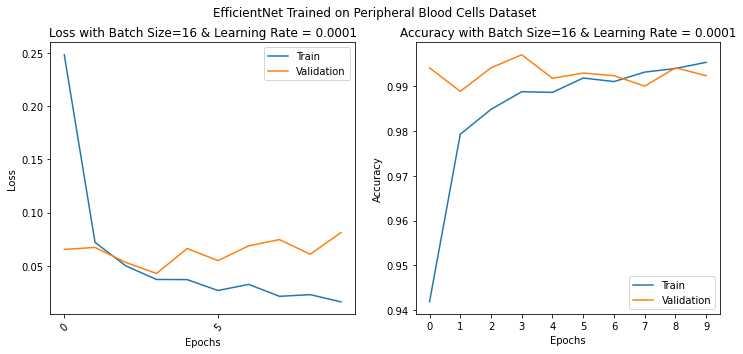

In [16]:
model_trainer.plotMetrics()

In [18]:
model_trainer.test(best_model_weights_path="/home/moayad/Downloads/StFX TA & XP & Student/advanced-project/3_best_model_weights.pth") #pick up the path

/tmp/ipykernel_21869/1690756125.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(best_model_weights_path))


Model into the path is loaded.


100%|█████████████████████████████████████████| 108/108 [00:52<00:00,  2.04it/s]

INFO | Test accuracy: 98.78472137451172%
